In [1]:
import numpy as np
import pandas as pd
import utils
import pymer4.models
import ast
import scipy.stats
import seaborn as sns
import statsmodels.api as sm

In [31]:
T_dur = 4
exp_measures = pd.read_csv("data/measures.csv")

print("Number of trials with outlier RTs: %i" % len(exp_measures[(exp_measures.RT > T_dur)]))
exp_measures = exp_measures[(exp_measures.RT < T_dur) | np.isnan(exp_measures.RT)]
print("Number of trials after excluding outlier RTs: %i" % len(exp_measures))

condition_map = utils.get_nudge_condition_map()
conditions = condition_map.values()
exp_measures["a_values"] = exp_measures.a_values.apply(ast.literal_eval).apply(tuple)
exp_measures["condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
exp_measures["a_values"] = exp_measures["a_values"].apply(str)

print("Number of trials with missing RTs: %i" % len(exp_measures[np.isnan(exp_measures.RT)]))
print("Of these, Go trials: %i" % len(exp_measures[exp_measures.is_go_decision & (np.isnan(exp_measures.RT))]))
exp_measures_no_missing_RT = exp_measures[~np.isnan(exp_measures.RT)]
print("Number of trials after excluding outlier and with outlier RTs: %i" % len(exp_measures_no_missing_RT))

Number of trials with outlier RTs: 24
Number of trials after excluding outlier RTs: 3776
Number of trials with missing RTs: 789
Of these, Go trials: 579
Number of trials after excluding outlier and with outlier RTs: 2987


In [3]:
column_names = {"Estimate": "$b$", "Z-stat": "$z$", "P-val": "$p$", "T-stat": "$t$", "F-stat": "$F$", "2.5_ci": "CI 2.5\%", "97.5_ci": "CI 97.5\%", "NumDF": "df"}
var_names = {"tta_0": "$\\textrm{TTA}_0$",
             "decision:tta_0": "decision:$\\textrm{TTA}_0$",
             "condition:tta_0": "condition:$\\textrm{TTA}_0$",
             "decision:condition:tta_0": "decision:condition:$\\textrm{TTA}_0$",
             "condition1": "Long acceleration",
             "condition2": "Acceleration nudge",
             "condition3": "Deceleration nudge",
             "condition4": "Long deceleration",
             "decision1": "decision"}

def p_formatted(p):
    if p>0.01:
        return "{:.2f}".format(p)
    elif p>0.001:
        return "{:.3f}".format(p)
    else:
        return "$<0.001$"

# Decision

In [4]:
model_is_go_decision = pymer4.models.Lmer("is_go_decision ~ tta_0 + condition + (1 | subj_id) ", data=exp_measures, family="binomial")
# model_is_go_decision = pymer4.models.Lmer("is_go_decision ~ tta_0 * condition + (tta_0 | subj_id) ", data=exp_measures, family="binomial")
model_is_go_decision_fit = model_is_go_decision.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"]})
# marginal_estimates, comparisons = model_is_go_decision.post_hoc(marginal_vars=["condition"])
print(model_is_go_decision.coefs)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_go_decision~tta_0+condition+(1|subj_id)

Family: binomial	 Inference: parametric

Number of observations: 3776	 Groups: {'subj_id': 19.0}

Log-likelihood: -1528.630 	 AIC: 3071.260

Random effects:

                Name    Var    Std
subj_id  (Intercept)  4.359  2.088

No random effect correlations specified

Fixed effects:

             Estimate     2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept) -9.300618 -10.693088 -7.908147  0.710457  0.000091   0.000023   
tta_0        1.815669   1.614914  2.016425  0.102428  6.145189   5.027456   
condition1  -0.783159  -1.068685 -0.497634  0.145679  0.456960   0.343460   
condition2  -0.134890  -0.415979  0.146200  0.143416  0.873812   0.659694   
condition3   0.495969   0.213161  0.778777  0.144292  1.642089   1.237584   
condition4   1.495729   1.199230  1.792227  0.151278  4.462587   3.317561   

             OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci   

In [188]:
df = model_is_go_decision.coefs.loc[:, ["Estimate", "SE", "Z-stat", "P-val"]]

df["P-val"] = df["P-val"].apply(p_formatted)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_decision.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrr", position="h", position_float="centering",
         hrules=True, label="tab:decision", caption="Coefficients of the mixed-effects logistic regression describing the final decision as a function of $\\textrm{TTA}_0$ and condition (with Constant speed as the reference category). Participant ID was included as a random intercept."
     )
)

# Response time

Full model with three-way interactions

In [5]:
model_RT = pymer4.models.Lmer("RT ~ 1 + decision + tta_0 + condition + decision:tta_0 + decision:condition + condition:tta_0 + decision:condition:tta_0 + (1 | subj_id)", data=exp_measures_no_missing_RT, family="gaussian")
model_RT_fit = model_RT.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=False)

In [6]:
model_RT.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.466754,-0.081427,1.014934,0.279689,2380.579426,1.668831,0.095282,.
decision1,-0.198900,-1.080161,0.682361,0.449631,2950.526956,-0.442363,0.658259,
tta_0,0.227244,0.118877,0.335612,0.055290,2951.409472,4.110016,0.000041,***
condition1,0.760708,0.014903,1.506512,0.380519,2949.296009,1.999130,0.045686,*
condition2,0.153215,-0.602907,0.909338,0.385784,2949.609520,0.397153,0.691283,
condition3,0.132926,-0.648734,0.914586,0.398813,2949.345780,0.333303,0.738929,
condition4,0.847675,-0.085378,1.780728,0.476056,2950.003165,1.780620,0.075077,.
decision1:tta_0,-0.177319,-0.351511,-0.003126,0.088875,2950.245769,-1.995139,0.046120,*
decision1:condition1,-0.509586,-1.852188,0.833016,0.685014,2949.319697,-0.743906,0.456993,
decision1:condition2,0.157451,-1.111353,1.426256,0.647361,2949.470719,0.243220,0.807852,


In [7]:
RT_anova = model_RT.anova()
RT_anova.index = ["decision", "tta_0", "condition", "decision:tta_0", "decision:condition", "condition:tta_0", "decision:condition:tta_0"]

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


In [8]:
RT_anova

,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
decision,5.268957,5.268957,1,2954.791564,19.544168,1.018439e-05,***
tta_0,11.788106,11.788106,1,2958.463459,43.725678,4.465596e-11,***
condition,3.249530,0.812382,4,2949.705637,3.013374,1.710747e-02,*
decision:tta_0,0.027541,0.027541,1,2953.572455,0.102158,7.492776e-01,
decision:condition,7.706533,1.926633,4,2949.914012,7.146470,1.007200e-05,***
condition:tta_0,4.546514,1.136629,4,2949.795109,4.216101,2.093003e-03,**
decision:condition:tta_0,8.407414,2.101853,4,2950.046198,7.796415,3.015044e-06,***


In [195]:
df = RT_anova.loc[:, ["SS", "MS", "NumDF", "F-stat", "P-val"]]
df["P-val"] = df["P-val"].apply(p_formatted)
styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_RT.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:RT", caption="ANOVA table based on the mixed-effects linear regression describing response time as a function of decision, $\\textrm{TTA}_0$, and condition."
     )
)

## Post-hoc comparisons

### Effect of decision on RT

In [200]:
RT_decision_marginal_estimates, RT_decision_comparisons = model_RT.post_hoc(marginal_vars=["decision"])
RT_decision_marginal_estimates

,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Stay,1.585,1.460,1.711,0.060,19.440
2,Go,0.569,0.443,0.696,0.061,20.097


In [201]:
RT_decision_comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
1,Stay - Go,1.016,0.965,1.066,0.026,2933.194,39.598,0.0,***


### Effect of TTA_0 on RT

In [25]:
RT_tta_marginal_estimates, RT_tta_comparisons = model_RT.post_hoc(marginal_vars=["tta_0"], grouping_vars=["condition", "decision"])

P-values adjusted by tukey method for family of 10 estimates


In [26]:
RT_tta_marginal_estimates["T-stat"] = RT_tta_marginal_estimates["Estimate"]/RT_tta_marginal_estimates["SE"]
RT_tta_marginal_estimates["P-val"] = scipy.stats.t.sf(np.abs(RT_tta_marginal_estimates["T-stat"]), RT_tta_marginal_estimates.DF)

In [27]:
RT_tta_marginal_estimates

,condition,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val
1,Constant speed,Stay,0.227,0.119,0.336,0.055,2951.409,4.127273,1.886263e-05
2,Long acceleration,Stay,0.060,-0.046,0.166,0.054,2950.913,1.111111,1.333055e-01
3,Acceleration nudge,Stay,0.176,0.068,0.285,0.055,2950.078,3.200000,6.944270e-04
4,Deceleration nudge,Stay,0.210,0.094,0.327,0.059,2952.250,3.559322,1.888376e-04
5,Long deceleration,Stay,0.066,-0.096,0.227,0.082,2952.399,0.804878,2.104774e-01
6,Constant speed,Go,0.050,-0.087,0.186,0.070,2950.550,0.714286,2.375535e-01
7,Long acceleration,Go,-0.008,-0.175,0.159,0.085,2950.633,-0.094118,4.625110e-01
8,Acceleration nudge,Go,-0.005,-0.149,0.140,0.074,2951.614,-0.067568,4.730672e-01
9,Deceleration nudge,Go,0.100,-0.025,0.224,0.063,2950.639,1.587302,5.627575e-02
10,Long deceleration,Go,0.535,0.422,0.648,0.058,2952.577,9.224138,2.645148e-20


### Effect of condition on RT

In [202]:
RT_condition_marginal_estimates, RT_condition_comparisons = model_RT.post_hoc(marginal_vars=["condition"], grouping_vars=["decision"])
# "Cell" means of the ANOVA
RT_condition_marginal_estimates

P-values adjusted by tukey method for family of 10 estimates


,condition,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Constant speed,Stay,1.603,1.470,1.736,0.065,26.047
2,Long acceleration,Stay,1.527,1.395,1.659,0.064,25.469
3,Acceleration nudge,Stay,1.501,1.368,1.634,0.065,25.978
4,Deceleration nudge,Stay,1.652,1.518,1.787,0.066,27.706
5,Long deceleration,Stay,1.643,1.498,1.788,0.072,39.390
6,Constant speed,Go,0.517,0.379,0.656,0.068,32.273
7,Long acceleration,Go,0.480,0.333,0.626,0.072,41.136
8,Acceleration nudge,Go,0.554,0.414,0.695,0.069,34.027
9,Deceleration nudge,Go,0.518,0.382,0.654,0.066,29.108
10,Long deceleration,Go,0.778,0.645,0.911,0.065,26.428


In [203]:
RT_condition_comparisons[RT_condition_comparisons.Contrast.str.contains("Constant speed")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
1,Constant speed - Long acceleration,Stay,0.076,-0.029,0.181,0.038,2950.133,1.977,0.278,
2,Constant speed - Acceleration nudge,Stay,0.102,-0.005,0.208,0.039,2950.228,2.607,0.069,.
3,Constant speed - Deceleration nudge,Stay,-0.049,-0.160,0.061,0.041,2951.182,-1.213,0.744,
4,Constant speed - Long deceleration,Stay,-0.040,-0.176,0.096,0.050,2953.465,-0.800,0.931,
11,Constant speed - Long acceleration,Go,0.038,-0.112,0.188,0.055,2950.863,0.688,0.959,
12,Constant speed - Acceleration nudge,Go,-0.037,-0.175,0.101,0.050,2949.141,-0.732,0.949,
13,Constant speed - Deceleration nudge,Go,-0.001,-0.129,0.128,0.047,2950.059,-0.014,1.000,
14,Constant speed - Long deceleration,Go,-0.260,-0.384,-0.137,0.045,2951.817,-5.762,0.000,***


# Negative rating

In [230]:
model_rating = pymer4.models.Lmer("is_negative_rating ~ tta_0 + decision + condition +  (1 | subj_id)", data=exp_measures, family="binomial")
model_rating_fit = model_rating.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=False)
model_rating.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-6.525545,-8.378744,-4.672345,0.945527,0.001466,0.000230,0.009350,0.001463,0.000230,0.009264,-6.901487,5.146082e-12,***
tta_0,0.544310,0.204647,0.883974,0.173301,1.723420,1.227092,2.420499,0.632815,0.550984,0.707645,3.140842,1.684626e-03,**
decision1,-2.673947,-3.168247,-2.179647,0.252198,0.068979,0.042077,0.113081,0.064528,0.040378,0.101593,-10.602551,2.899611e-26,***
condition1,-0.147224,-0.880850,0.586401,0.374306,0.863100,0.414430,1.797508,0.463260,0.293002,0.642539,-0.393327,6.940782e-01,
condition2,0.495736,-0.171664,1.163136,0.340516,1.641706,0.842263,3.199953,0.621457,0.457189,0.761902,1.455837,1.454377e-01,
condition3,0.733440,0.080426,1.386454,0.333177,2.082231,1.083749,4.000638,0.675560,0.520096,0.800026,2.201355,2.771089e-02,*
condition4,3.415723,2.821014,4.010432,0.303429,30.438939,16.793865,55.170684,0.968192,0.943801,0.982197,11.257090,2.136989e-29,***


Are individual differences significant? Seemingly, no

In [231]:
wald_stat = ((model_rating.ranef_var["Var"]/model_rating.ranef_var["Std"])**2).values[0]
scipy.stats.chi2.sf(wald_stat, 1)

0.22564657770380997

In [232]:
df = model_rating.coefs.loc[:, ["Estimate", "SE", "Z-stat", "P-val"]]

df["P-val"] = df["P-val"].apply(p_formatted)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_rating.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:rating", caption="Coefficients of the mixed-effects logistic regression describing occurrence of the negative rating as a function of $\\textrm{TTA}_0$ and condition (with Constant speed as the reference category). Participant ID was included as a random intercept."
     )
)

In [243]:
model_rating_stay = pymer4.models.Lmer("is_negative_rating ~ tta_0 + condition +  (1 | subj_id)", data=exp_measures[exp_measures.decision=="Stay"], family="binomial")
model_rating_stay_fit = model_rating_stay.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"]}, summarize=True)
model_rating_stay.coefs

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: is_negative_rating~tta_0+condition+(1|subj_id)

Family: binomial	 Inference: parametric

Number of observations: 1882	 Groups: {'subj_id': 19.0}

Log-likelihood: -315.828 	 AIC: 645.655

Random effects:

                Name    Var    Std
subj_id  (Intercept)  3.121  1.767

No random effect correlations specified

Fixed effects:


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.352669,-14.162624,-8.542714,1.433677,0.000012,7.067254e-07,0.000195,0.000012,7.067249e-07,0.000195,-7.918569,2.402600e-15,***
tta_0,1.418137,0.918030,1.918243,0.255161,4.129418,2.504352e+00,6.808987,0.805046,7.146405e-01,0.871942,5.557807,2.731849e-08,***
condition1,-0.414384,-1.342535,0.513767,0.473555,0.660747,2.611828e-01,1.671577,0.397861,2.070935e-01,0.625689,-0.875049,3.815475e-01,
condition2,-0.484264,-1.476577,0.508049,0.506291,0.616150,2.284183e-01,1.662045,0.381246,1.859450e-01,0.624349,-0.956493,3.388231e-01,
condition3,1.141074,0.366348,1.915800,0.395276,3.130128,1.442457e+00,6.792373,0.757877,5.905761e-01,0.871669,2.886779,3.892075e-03,**
condition4,4.877734,4.068535,5.686932,0.412864,131.332687,5.847124e+01,294.987340,0.992443,9.831851e-01,0.996621,11.814381,3.289620e-32,***


In [245]:
rating_condition_marginal_estimates, rating_condition_comparisons = model_rating_stay.post_hoc(marginal_vars=["condition"])

P-values adjusted by tukey method for family of 10 estimates


In [247]:
rating_condition_comparisons[rating_condition_comparisons.Contrast.str.contains("Constant speed")]

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,Z-stat,P-val,Sig
1,Constant speed - Long acceleration,0.414,-0.877,1.706,0.474,inf,0.875,0.906,
2,Constant speed - Acceleration nudge,0.484,-0.897,1.865,0.506,inf,0.956,0.874,
3,Constant speed - Deceleration nudge,-1.141,-2.219,-0.063,0.395,inf,-2.887,0.032,*
4,Constant speed - Long deceleration,-4.878,-6.004,-3.752,0.413,inf,-11.814,0.000,***


# Supplementary material: Log-transformed response time

In [ ]:
exp_measures["log_RT"] = exp_measures["RT"].apply(np.log)

In [18]:
model_log_RT = pymer4.models.Lmer("log_RT ~ 1 + decision + tta_0 + condition + decision:tta_0 + decision:condition + condition:tta_0 + decision:condition:tta_0 + (1 | subj_id)", data=exp_measures[exp_measures.RT<5], family="gaussian")
model_log_RT_fit = model_log_RT.fit(factors={"condition": ["Constant speed", "Long acceleration", "Acceleration nudge", "Deceleration nudge", "Long deceleration"], "decision": ["Stay", "Go"]}, summarize=False)

<Axes: ylabel='RT'>

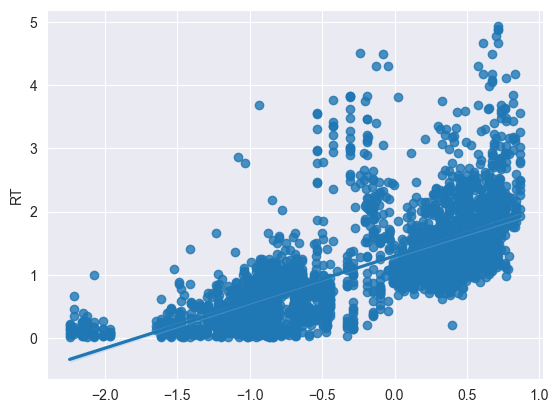

In [19]:
sns.regplot(x=np.asarray(model_log_RT.fits), y=model_log_RT.data.RT[~np.isnan(model_log_RT.data.RT)], fit_reg=True)

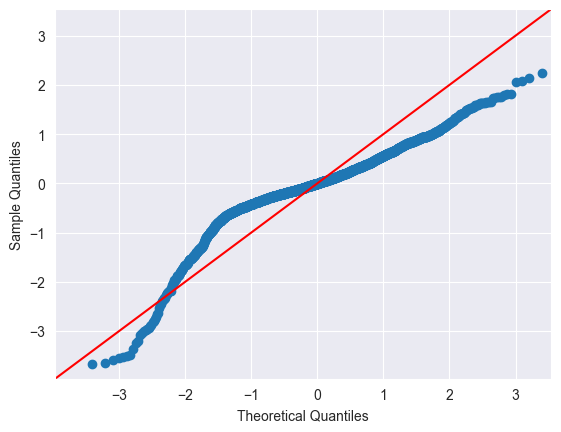

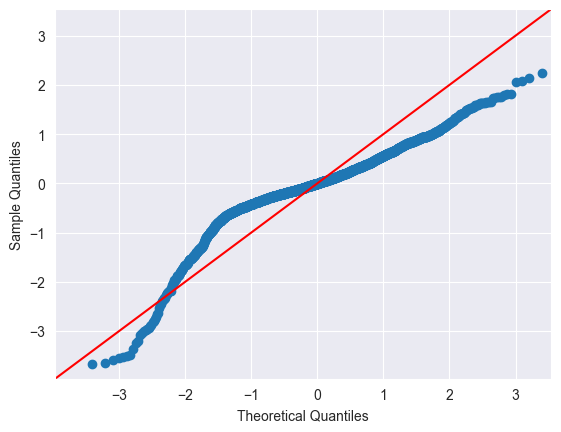

In [20]:
sm.qqplot(np.asarray(model_log_RT.residuals), line ='45')

In [22]:
model_log_RT.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.264015,-0.958286,0.430256,0.354226,1900.673145,-0.745328,0.456166,
decision1,-1.173924,-2.281593,-0.066255,0.565148,2967.789457,-2.077198,0.037869,*
tta_0,0.111232,-0.024552,0.247015,0.069279,2968.381718,1.605572,0.108474,
condition1,0.535916,-0.399893,1.471726,0.477463,2966.923074,1.122426,0.261772,
condition2,0.033550,-0.916246,0.983346,0.484598,2967.125690,0.069233,0.944809,
condition3,0.107242,-0.871911,1.086394,0.499577,2966.974710,0.214665,0.830043,
condition4,0.518378,-0.645508,1.682265,0.593831,2967.604976,0.872940,0.382767,
decision1:tta_0,-0.031061,-0.249956,0.187834,0.111683,2967.584556,-0.278117,0.780942,
decision1:condition1,-0.401340,-2.089818,1.287139,0.861484,2966.944920,-0.465870,0.641343,
decision1:condition2,-0.157295,-1.753306,1.438716,0.814306,2967.039837,-0.193164,0.846844,


In [24]:
log_RT_anova = model_log_RT.anova()
log_RT_anova.index = ["decision", "tta_0", "condition", "decision:tta_0", "decision:condition", "condition:tta_0", "decision:condition:tta_0"]

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


In [26]:
log_RT_anova

,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
decision,21.555638,21.555638,1,2970.966812,50.457068,1.518008e-12,***
tta_0,9.462617,9.462617,1,2973.886124,22.149932,2.636895e-06,***
condition,2.925614,0.731403,4,2967.274377,1.712057,1.444413e-01,
decision:tta_0,2.368948,2.368948,1,2970.064166,5.545193,1.859624e-02,*
decision:condition,5.226688,1.306672,4,2967.381090,3.058635,1.583226e-02,*
condition:tta_0,4.066374,1.016594,4,2967.352500,2.379625,4.961455e-02,*
decision:condition:tta_0,5.837550,1.459388,4,2967.482320,3.416110,8.545953e-03,**


In [28]:
df = log_RT_anova.loc[:, ["SS", "MS", "NumDF", "F-stat", "P-val"]]

p_func = lambda p: "{:.2f}".format(p) if p>0.001 else "$<0.001$"
df["P-val"] = df["P-val"].apply(p_func)

styler = df.rename(columns=column_names, index=var_names).style.format(precision=2)

with open('figures/tab_log_RT.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:log_RT", caption="ANOVA table based on the mixed-effects linear regression describing log-transformed response time as a function of decision, $\\textrm{TTA}_0$, and condition."
     )
)

## Log-RT: post-hoc comparisons

In [30]:
log_RT_marginal_estimates, log_RT_comparisons = model_log_RT.post_hoc(marginal_vars=["decision"])
# "Cell" means of the ANOVA
log_RT_marginal_estimates

,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Stay,0.293,0.103,0.483,0.091,18.683
2,Go,-0.994,-1.185,-0.803,0.091,19.146


In [32]:
log_RT_comparisons

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
1,Stay - Go,1.287,1.224,1.35,0.032,2977.877,39.886,0.0,***


In [34]:
log_RT_marginal_estimates, log_RT_comparisons = model_log_RT.post_hoc(marginal_vars=["condition"], grouping_vars=["decision"])
# "Cell" means of the ANOVA
log_RT_marginal_estimates

P-values adjusted by tukey method for family of 10 estimates


,condition,decision,Estimate,2.5_ci,97.5_ci,SE,DF
1,Constant speed,Stay,0.292,0.095,0.490,0.096,22.945
2,Long acceleration,Stay,0.263,0.065,0.460,0.095,22.626
3,Acceleration nudge,Stay,0.249,0.051,0.446,0.096,22.972
4,Deceleration nudge,Stay,0.329,0.129,0.528,0.097,24.013
5,Long deceleration,Stay,0.332,0.121,0.542,0.103,30.968
6,Constant speed,Go,-1.037,-1.241,-0.833,0.099,26.965
7,Long acceleration,Go,-1.153,-1.365,-0.941,0.104,32.407
8,Acceleration nudge,Go,-0.992,-1.198,-0.786,0.100,28.052
9,Deceleration nudge,Go,-0.978,-1.179,-0.777,0.098,24.969
10,Long deceleration,Go,-0.810,-1.009,-0.612,0.096,23.248


In [36]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Long deceleration")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
4,Constant speed - Long deceleration,Stay,-0.039,-0.209,0.130,0.062,2970.179,-0.633,0.970,
7,Long acceleration - Long deceleration,Stay,-0.069,-0.238,0.100,0.062,2971.763,-1.113,0.800,
9,Acceleration nudge - Long deceleration,Stay,-0.083,-0.254,0.088,0.063,2972.214,-1.322,0.677,
10,Deceleration nudge - Long deceleration,Stay,-0.003,-0.176,0.170,0.063,2967.929,-0.046,1.000,
14,Constant speed - Long deceleration,Go,-0.227,-0.382,-0.071,0.057,2968.739,-3.985,0.001,***
17,Long acceleration - Long deceleration,Go,-0.342,-0.520,-0.165,0.065,2970.369,-5.267,0.000,***
19,Acceleration nudge - Long deceleration,Go,-0.181,-0.342,-0.021,0.059,2968.554,-3.088,0.017,*
20,Deceleration nudge - Long deceleration,Go,-0.168,-0.315,-0.021,0.054,2967.635,-3.124,0.015,*


In [38]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Acceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
2,Constant speed - Acceleration nudge,Stay,0.043,-0.091,0.177,0.049,2967.537,0.885,0.903,
5,Long acceleration - Acceleration nudge,Stay,0.014,-0.119,0.146,0.048,2966.992,0.285,0.999,
8,Acceleration nudge - Deceleration nudge,Stay,-0.080,-0.220,0.060,0.051,2970.674,-1.558,0.524,
9,Acceleration nudge - Long deceleration,Stay,-0.083,-0.254,0.088,0.063,2972.214,-1.322,0.677,
12,Constant speed - Acceleration nudge,Go,-0.045,-0.219,0.128,0.063,2966.812,-0.712,0.954,
15,Long acceleration - Acceleration nudge,Go,-0.161,-0.354,0.032,0.071,2967.578,-2.276,0.153,
18,Acceleration nudge - Deceleration nudge,Go,-0.013,-0.180,0.153,0.061,2967.249,-0.220,0.999,
19,Acceleration nudge - Long deceleration,Go,-0.181,-0.342,-0.021,0.059,2968.554,-3.088,0.017,*


In [40]:
log_RT_comparisons[log_RT_comparisons.Contrast.str.contains("Deceleration nudge")]

,Contrast,decision,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
3,Constant speed - Deceleration nudge,Stay,-0.036,-0.175,0.102,0.051,2968.264,-0.718,0.952,
6,Long acceleration - Deceleration nudge,Stay,-0.066,-0.204,0.072,0.050,2970.323,-1.309,0.686,
8,Acceleration nudge - Deceleration nudge,Stay,-0.080,-0.220,0.060,0.051,2970.674,-1.558,0.524,
10,Deceleration nudge - Long deceleration,Stay,-0.003,-0.176,0.170,0.063,2967.929,-0.046,1.000,
13,Constant speed - Deceleration nudge,Go,-0.059,-0.220,0.103,0.059,2967.456,-0.991,0.860,
16,Long acceleration - Deceleration nudge,Go,-0.174,-0.357,0.008,0.067,2968.330,-2.605,0.070,.
18,Acceleration nudge - Deceleration nudge,Go,-0.013,-0.180,0.153,0.061,2967.249,-0.220,0.999,
20,Deceleration nudge - Long deceleration,Go,-0.168,-0.315,-0.021,0.054,2967.635,-3.124,0.015,*
